# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.mean((y_true - y_predicted)**2)

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    numenator = np.sum((y_true - y_predicted)**2)
    denomenator = np.sum((np.mean(y_true) - y_true)**2)
    return 1 - numenator / denomenator

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class StdScaler:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X: np.array):
        self.mean = np.mean(X, axis = 0)
        self.std = np.std(X, axis = 0)
        return self
    
    def transform(self, X):
        return (X - self.mean) / self.std
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def reverse(self, X):
        return X * self.std + self.mean

In [6]:
class NormalLR:
    def __init__(self):
        self.omega = None
        self.scaler_X = StdScaler()
        self.scaler_y = StdScaler()
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        
        X = self.scaler_X.fit_transform(X)
        y = self.scaler_y.fit_transform(y)
        X = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
        self.omega = np.linalg.inv((X.T).dot(X)).dot(X.T).dot(y)
        
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        if self.omega is not None:

            X = self.scaler_X.transform(X)
            X = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
            y = X.dot(self.omega)
            return self.scaler_y.reverse(y)

In [7]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [8]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009898042977436565, R2: 0.9989774330214095


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [9]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.omega = None
        self.scaler_X = StdScaler()
        self.scaler_y = StdScaler()
    
    def loss_grad(self, X: np.array, omega: np.array, y: np.array):
        return (X.T).dot(X.dot(omega)-y) / X.shape[0]
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        
        X = self.scaler_X.fit_transform(X)
        y = self.scaler_y.fit_transform(y)
        
        X = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
        cur_point = np.random.rand(X.shape[1])
        # cur_point = np.ones(X.shape[1])
        for _ in range(self.iterations):
            next_point = cur_point - self.alpha * (self.loss_grad(X, cur_point, y) - self.l * np.sign(cur_point))
            if np.linalg.norm(next_point - cur_point) < 0.0000001:
                break
            cur_point = next_point
        self.omega = cur_point

    def predict(self, X:np.ndarray):
        if self.omega is not None:
            X = self.scaler_X.transform(X)
            X = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X))
            y = X.dot(self.omega)
            return self.scaler_y.reverse(y)

In [10]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [27]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

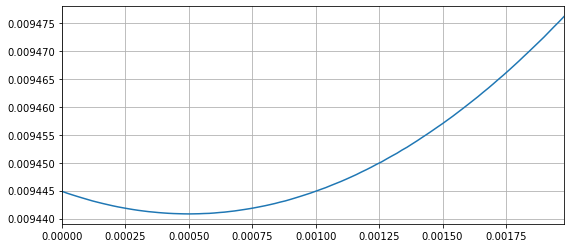

In [28]:
build_plot(X_train, y_train, X_val, y_val)

In [29]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.00936075984050892, R2: 0.994468510280951


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [30]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [31]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22266311.080836885, R2: 0.6872797475661053


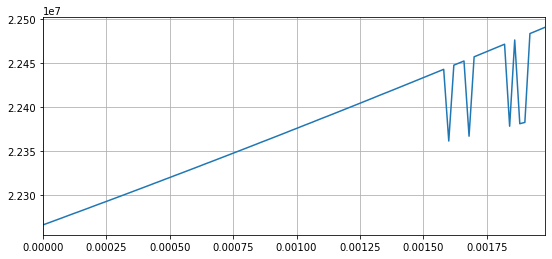

In [32]:
build_plot(X_train, y_train, X_val, y_val)

In [33]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22266285.68050475, R2: 0.6872801043022637


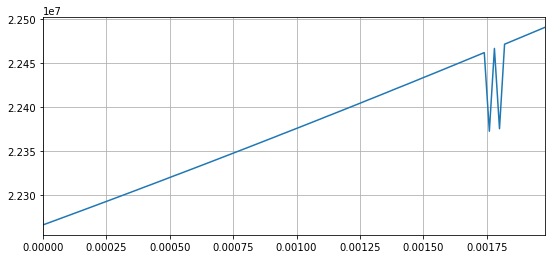

In [34]:
build_plot(X_train, y_train, X_val, y_val)

### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [35]:
feature_names =\
"""1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per $10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
""".split(sep = '\n')



In [36]:
for value, name in sorted(zip(regr.omega[1:], feature_names), key= lambda x: x[0], reverse = True):
    x = list(map(str, name.split(sep="-")))
    print(f'{value:6.3f}   {x[0]:<14s} {x[1]}')

 0.305   9. RAD          index of accessibility to radial highways
 0.278   6. RM           average number of rooms per dwelling
 0.135   2. ZN           proportion of residential land zoned for lots over 25,000 sq.ft.
 0.085   12. B           1000(Bk 
 0.063   4. CHAS         Charles River dummy variable (1 if tract bounds river; 0 otherwise)
 0.032   7. AGE          proportion of owner
-0.015   3. INDUS        proportion of non
-0.101   1. CRIM         per capita crime rate by town
-0.210   11. PTRATIO     pupil
-0.214   5. NOX          nitric oxides concentration (parts per 10 million)
-0.262   10. TAX         full
-0.351   8. DIS          weighted distances to five Boston employment centres
-0.427   13. LSTAT       % lower status of the population


Самые значимые признаки с положительными коэффициентами --- RAD и RM. Действительно, вполне логично, что чем к трассе (highway), тем выгоднее расположение дома, а так же чем больше комнат, тем дороже жилье

Самые значимые признаки с отрицательными коэффициентами --- LSTAT и DIS. Получается, что на стоимость жилья (уменьшаяя его) сильно влияет то, на сколько плохо живут люди, т.е. бедность, необразованность и тд; а так же удаленность от работы --- чем больше, тем дальше надо добираться и тем менее привлекательное жилье

На самом деле еще достаточно важными признаками являются NOX, PTRATIO. Первый говорит о экологической загрязненности района (чем больше, тем меньше хочется жить в таком месте). Второй признак --- отношение числа учащихся к преподавателям в районе. Получается, что чем меньше преподавателей в рацоне, чем больше необразованности, тем менее привлекательный район. По идее, этот параметр должен коррелировать с LSTAT.

Все остальные параметры не так сильно влияют на ценообразование. Но отдельно хочется выделить CHAS, AGE, INDUS.